# Fixed Grid Search + Inverted Strategy Testing

**Objectives:**
1. Fix parameter validation in grid search (skip invalid window sizes)
2. Implement inverted strategy (flip signals: long when high, short when low)
3. Compare original vs inverted across all periods

**Hypothesis:** Current strategy might have signals backwards - test if opposite works better.

---

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Tuple, Dict, Optional, List
from itertools import product
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

Path('../results/backtest_inverted').mkdir(parents=True, exist_ok=True)
Path('../results/figures').mkdir(parents=True, exist_ok=True)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Setup complete")

✓ Setup complete


## 2. Load Data

In [2]:
df = pd.read_csv('../data/processed/full_processed_data_hmm.csv', index_col=0, parse_dates=True)

# Data splits
train_data = df.loc['2015-01-01':'2018-12-31'].copy()
val_data = df.loc['2019-01-01':'2019-12-31'].copy()
test_data = df.loc['2020-01-01':'2024-12-31'].copy()
data_2015_2019 = df.loc['2015-01-01':'2019-12-31'].copy()
data_2020_2024 = df.loc['2020-01-01':'2024-12-31'].copy()
data_2025 = df.loc['2025-01-01':'2025-12-31'].copy()

print(f"Data loaded: {len(df)} observations")
print(f"\nSplits:")
print(f"  Train:      {len(train_data)} obs")
print(f"  Validation: {len(val_data)} obs")
print(f"  Test:       {len(test_data)} obs")
print(f"  2015-2019:  {len(data_2015_2019)} obs")
print(f"  2020-2024:  {len(data_2020_2024)} obs")
print(f"  2025:       {len(data_2025)} obs")

Data loaded: 2887 observations

Splits:
  Train:      1037 obs
  Validation: 265 obs
  Test:       1322 obs
  2015-2019:  1302 obs
  2020-2024:  1322 obs
  2025:       263 obs


## 3. Simplified Backtest Functions

**Key Change:** Add `invert_signals` parameter to flip strategy logic.

In [3]:
def estimate_ou_parameters(spread: pd.Series, dt: float = 1.0) -> Dict[str, float]:
    """Estimate OU parameters using OLS."""
    X = spread.values[:-1]
    dX = spread.diff().dropna().values
    
    X_design = np.column_stack([np.ones(len(X)), X])
    beta_hat = np.linalg.lstsq(X_design, dX, rcond=None)[0]
    alpha, beta = beta_hat
    
    epsilon = dX - (alpha + beta * X)
    
    theta = -beta / dt
    mu = -alpha / beta if beta != 0 else spread.mean()
    sigma = np.std(epsilon) * np.sqrt(1 / dt)
    half_life = np.log(2) / theta if theta > 0 else np.inf
    
    return {'theta': theta, 'mu': mu, 'sigma': sigma, 'half_life': half_life}


def backtest_ou(
    data: pd.DataFrame,
    ou_window: int = 126,
    entry_z: float = 2.0,
    exit_z: float = 0.5,
    stop_z: float = 3.0,
    position_size: float = 0.5,
    capital: float = 1_000_000,
    invert_signals: bool = False
) -> pd.DataFrame:
    """
    Backtest OU-based mean reversion strategy.
    
    Parameters
    ----------
    invert_signals : bool
        If True, flip signals (long when z > entry, short when z < -entry)
    """
    results = []
    position = 0
    equity = capital
    notional = capital * position_size
    
    for i in range(ou_window, len(data)):
        current_spread = data['spread'].iloc[i]
        regime = data['regime'].iloc[i]
        vix = data['vix'].iloc[i]
        
        # Estimate OU parameters
        hist = data['spread'].iloc[i-ou_window:i]
        ou_params = estimate_ou_parameters(hist)
        z_score = (current_spread - ou_params['mu']) / ou_params['sigma'] if ou_params['sigma'] > 0 else 0
        z_score = np.clip(z_score, -100, 100)  # Prevent extreme values
        
        # Generate signal
        signal = position
        
        # Stop loss
        if position != 0 and abs(z_score) > stop_z:
            signal = 0
        
        # Exit on mean reversion
        if position != 0 and abs(z_score) < exit_z:
            signal = 0
        
        # Entry signals
        if position == 0:
            if invert_signals:
                # INVERTED: Long when spread is HIGH (fade mean reversion)
                if z_score > entry_z:
                    signal = +1  # Long spread
                elif z_score < -entry_z:
                    signal = -1  # Short spread
            else:
                # ORIGINAL: Short when spread is HIGH (trade mean reversion)
                if z_score > entry_z:
                    signal = -1  # Short spread
                elif z_score < -entry_z:
                    signal = +1  # Long spread
        
        # Regime filter: don't enter during stress, exit if regime changes
        if regime == 1:
            if position == 0:
                signal = 0
            else:
                signal = 0  # Exit
        
        # VIX filter
        if vix > 30 and position == 0:
            signal = 0
        
        # Calculate P&L (ZERO COSTS for pure signal quality)
        pnl = 0
        if i > ou_window and position != 0:
            spread_chg = (current_spread - data['spread'].iloc[i-1]) / 10000
            pnl = spread_chg * notional if position == 1 else -spread_chg * notional
        
        equity += pnl
        position = signal
        
        results.append({
            'spread': current_spread,
            'z_score': z_score,
            'position': position,
            'pnl': pnl,
            'equity': equity,
            'ou_mu': ou_params['mu'],
            'ou_sigma': ou_params['sigma']
        })
    
    return pd.DataFrame(results, index=data.index[ou_window:])


def backtest_zscore(
    data: pd.DataFrame,
    window: int = 60,
    entry_z: float = 2.0,
    exit_z: float = 0.5,
    stop_z: float = 3.0,
    position_size: float = 0.5,
    capital: float = 1_000_000,
    invert_signals: bool = False
) -> pd.DataFrame:
    """
    Backtest classic z-score strategy.
    
    Parameters
    ----------
    invert_signals : bool
        If True, flip signals (long when z > entry, short when z < -entry)
    """
    results = []
    position = 0
    equity = capital
    notional = capital * position_size
    
    for i in range(window, len(data)):
        current_spread = data['spread'].iloc[i]
        regime = data['regime'].iloc[i]
        vix = data['vix'].iloc[i]
        
        # Calculate z-score
        hist = data['spread'].iloc[i-window:i]
        mean = hist.mean()
        std = hist.std()
        z_score = (current_spread - mean) / std if std > 0 else 0
        
        # Generate signal
        signal = position
        
        # Stop loss
        if position != 0 and abs(z_score) > stop_z:
            signal = 0
        
        # Exit
        if position != 0 and abs(z_score) < exit_z:
            signal = 0
        
        # Entry
        if position == 0:
            if invert_signals:
                # INVERTED
                if z_score > entry_z:
                    signal = +1
                elif z_score < -entry_z:
                    signal = -1
            else:
                # ORIGINAL
                if z_score > entry_z:
                    signal = -1
                elif z_score < -entry_z:
                    signal = +1
        
        # Filters
        if regime == 1:
            if position == 0:
                signal = 0
            else:
                signal = 0
        
        if vix > 30 and position == 0:
            signal = 0
        
        # P&L (ZERO COSTS)
        pnl = 0
        if i > window and position != 0:
            spread_chg = (current_spread - data['spread'].iloc[i-1]) / 10000
            pnl = spread_chg * notional if position == 1 else -spread_chg * notional
        
        equity += pnl
        position = signal
        
        results.append({
            'spread': current_spread,
            'z_score': z_score,
            'position': position,
            'pnl': pnl,
            'equity': equity
        })
    
    return pd.DataFrame(results, index=data.index[window:])


print("✓ Backtest functions defined")

✓ Backtest functions defined


## 4. Performance Metrics

In [4]:
def calc_metrics(results: pd.DataFrame, capital: float = 1_000_000) -> dict:
    """Calculate performance metrics."""
    total_ret = (results['equity'].iloc[-1] - capital) / capital
    daily_ret = results['pnl'] / capital
    sharpe = (daily_ret.mean() / daily_ret.std()) * np.sqrt(252) if daily_ret.std() > 0 else 0
    
    running_max = results['equity'].expanding().max()
    dd = (results['equity'] - running_max) / running_max
    max_dd = dd.min()
    
    n_trades = (results['position'].diff().fillna(0) != 0).sum() // 2
    
    win_days = (daily_ret > 0).sum()
    lose_days = (daily_ret < 0).sum()
    win_rate = win_days / (win_days + lose_days) if (win_days + lose_days) > 0 else 0
    
    final_pnl = results['equity'].iloc[-1] - capital
    
    return {
        'return': total_ret,
        'sharpe': sharpe,
        'max_dd': max_dd,
        'trades': int(n_trades),
        'win_rate': win_rate,
        'pnl': final_pnl
    }

print("✓ Metrics function defined")

✓ Metrics function defined


## 5. Fixed Grid Search with Parameter Validation

In [5]:
def grid_search_fixed(
    data: pd.DataFrame,
    method: str = 'ou',
    invert: bool = False
) -> pd.DataFrame:
    """
    Fixed grid search with proper parameter validation.
    
    Key fix: Skip combinations where window > len(data)
    """
    print(f"\nGrid Search: {method.upper()} | Inverted={invert}")
    print("=" * 80)
    print(f"Data period: {data.index.min().date()} to {data.index.max().date()}")
    print(f"Data length: {len(data)} observations")
    
    # Reduced parameter grid (avoid 504 which is too large for val data)
    if method == 'ou':
        param_grid = {
            'window': [40, 60, 90, 126],  # Removed 252, 504
            'entry_z': [1.5, 2.0, 2.5],
            'exit_z': [0.3, 0.5, 0.7],
            'stop_z': [2.5, 3.0, 3.5]
        }
    else:  # zscore
        param_grid = {
            'window': [40, 60, 90],
            'entry_z': [1.5, 2.0, 2.5],
            'exit_z': [0.3, 0.5, 0.7],
            'stop_z': [2.5, 3.0, 3.5]
        }
    
    # Generate combinations
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    combinations = list(product(*values))
    
    print(f"Total combinations: {len(combinations)}")
    
    results = []
    skipped = 0
    
    for combo in tqdm(combinations, desc="Testing configs"):
        params = dict(zip(keys, combo))
        
        # VALIDATION: Skip if window > data length
        if params['window'] >= len(data):
            skipped += 1
            continue
        
        try:
            if method == 'ou':
                backtest_results = backtest_ou(
                    data,
                    ou_window=params['window'],
                    entry_z=params['entry_z'],
                    exit_z=params['exit_z'],
                    stop_z=params['stop_z'],
                    invert_signals=invert
                )
            else:
                backtest_results = backtest_zscore(
                    data,
                    window=params['window'],
                    entry_z=params['entry_z'],
                    exit_z=params['exit_z'],
                    stop_z=params['stop_z'],
                    invert_signals=invert
                )
            
            metrics = calc_metrics(backtest_results)
            
            results.append({
                **params,
                **metrics
            })
            
        except Exception as e:
            print(f"\nError with {params}: {e}")
            continue
    
    print(f"\n✓ Completed: {len(results)} valid configs, {skipped} skipped")
    
    results_df = pd.DataFrame(results).sort_values('sharpe', ascending=False)
    
    print(f"\nTop 5 by Sharpe:")
    print(results_df[['window', 'entry_z', 'exit_z', 'sharpe', 'return', 'trades', 'pnl']].head().to_string(index=False))
    
    return results_df

print("✓ Fixed grid search defined")

✓ Fixed grid search defined


## 6. Run Grid Search on Validation Data (2019)

Test both original and inverted strategies.

In [6]:
print("\n" + "=" * 100)
print("GRID SEARCH ON VALIDATION DATA (2019)")
print("=" * 100)

# OU - Original
grid_ou_original = grid_search_fixed(val_data, method='ou', invert=False)

# OU - Inverted
grid_ou_inverted = grid_search_fixed(val_data, method='ou', invert=True)

# Z-Score - Original
grid_z_original = grid_search_fixed(val_data, method='zscore', invert=False)

# Z-Score - Inverted
grid_z_inverted = grid_search_fixed(val_data, method='zscore', invert=True)

# Save results
grid_ou_original.to_csv('../results/backtest_inverted/grid_ou_original.csv', index=False)
grid_ou_inverted.to_csv('../results/backtest_inverted/grid_ou_inverted.csv', index=False)
grid_z_original.to_csv('../results/backtest_inverted/grid_z_original.csv', index=False)
grid_z_inverted.to_csv('../results/backtest_inverted/grid_z_inverted.csv', index=False)

print("\n✓ Grid search results saved")


GRID SEARCH ON VALIDATION DATA (2019)

Grid Search: OU | Inverted=False
Data period: 2019-01-01 to 2019-12-31
Data length: 265 observations
Total combinations: 108


Testing configs: 100%|██████████| 108/108 [00:02<00:00, 47.18it/s]



✓ Completed: 108 valid configs, 0 skipped

Top 5 by Sharpe:
 window  entry_z  exit_z    sharpe        return  trades  pnl
     40      2.0     0.3  0.792176  4.000000e-06      78  4.0
     40      2.0     0.3  0.492575  2.500000e-06      77  2.5
     90      2.5     0.3  0.343912  1.500000e-06      41  1.5
     90      2.5     0.3 -0.113576 -5.000000e-07      44 -0.5
     90      2.5     0.7 -0.120263 -5.000000e-07      42 -0.5

Grid Search: OU | Inverted=True
Data period: 2019-01-01 to 2019-12-31
Data length: 265 observations
Total combinations: 108


Testing configs: 100%|██████████| 108/108 [00:02<00:00, 48.73it/s]



✓ Completed: 108 valid configs, 0 skipped

Top 5 by Sharpe:
 window  entry_z  exit_z   sharpe   return  trades  pnl
    126      2.5     0.7 3.159514 0.000012      29 12.0
    126      2.5     0.5 3.159514 0.000012      29 12.0
    126      2.0     0.5 2.980349 0.000012      29 11.5
    126      2.0     0.7 2.980349 0.000012      29 11.5
     40      1.5     0.5 2.888805 0.000018      82 18.5

Grid Search: ZSCORE | Inverted=False
Data period: 2019-01-01 to 2019-12-31
Data length: 265 observations
Total combinations: 81


Testing configs: 100%|██████████| 81/81 [00:00<00:00, 124.01it/s]



✓ Completed: 81 valid configs, 0 skipped

Top 5 by Sharpe:
 window  entry_z  exit_z   sharpe   return  trades  pnl
     40      2.5     0.5 0.987382 0.000005       5  4.5
     40      2.5     0.5 0.934500 0.000004       9  4.0
     40      2.5     0.7 0.904502 0.000003       9  3.5
     40      2.5     0.5 0.872621 0.000004       4  4.0
     40      2.5     0.7 0.843547 0.000003       5  3.5

Grid Search: ZSCORE | Inverted=True
Data period: 2019-01-01 to 2019-12-31
Data length: 265 observations
Total combinations: 81


Testing configs: 100%|██████████| 81/81 [00:00<00:00, 120.52it/s]


✓ Completed: 81 valid configs, 0 skipped

Top 5 by Sharpe:
 window  entry_z  exit_z  sharpe   return  trades  pnl
     90      2.0     0.3 2.09051 0.000006       0  6.0
     90      2.0     0.7 2.09051 0.000006       0  6.0
     90      2.0     0.3 2.09051 0.000006       0  6.0
     90      2.0     0.3 2.09051 0.000006       0  6.0
     90      2.0     0.5 2.09051 0.000006       0  6.0

✓ Grid search results saved


## 7. Compare Original vs Inverted on All Periods

Use best configs from validation set, test on all periods.

In [7]:
# Get best params from each grid search
best_ou_orig = grid_ou_original.iloc[0].to_dict()
best_ou_inv = grid_ou_inverted.iloc[0].to_dict()
best_z_orig = grid_z_original.iloc[0].to_dict()
best_z_inv = grid_z_inverted.iloc[0].to_dict()

print("\nBest Configurations from Validation:")
print("=" * 80)
print(f"\nOU Original:  window={int(best_ou_orig['window'])}, entry={best_ou_orig['entry_z']}, exit={best_ou_orig['exit_z']}, Sharpe={best_ou_orig['sharpe']:.2f}")
print(f"OU Inverted:  window={int(best_ou_inv['window'])}, entry={best_ou_inv['entry_z']}, exit={best_ou_inv['exit_z']}, Sharpe={best_ou_inv['sharpe']:.2f}")
print(f"Z  Original:  window={int(best_z_orig['window'])}, entry={best_z_orig['entry_z']}, exit={best_z_orig['exit_z']}, Sharpe={best_z_orig['sharpe']:.2f}")
print(f"Z  Inverted:  window={int(best_z_inv['window'])}, entry={best_z_inv['entry_z']}, exit={best_z_inv['exit_z']}, Sharpe={best_z_inv['sharpe']:.2f}")

# Test on all periods
periods = {
    '2015-2019': data_2015_2019,
    '2020-2024': data_2020_2024,
    '2025': data_2025
}

comparison_results = []

for period_name, period_data in periods.items():
    print(f"\n{'='*80}")
    print(f"Testing on {period_name} ({len(period_data)} obs)")
    print(f"{'='*80}")
    
    # OU Original
    res_ou_orig = backtest_ou(
        period_data,
        ou_window=int(best_ou_orig['window']),
        entry_z=best_ou_orig['entry_z'],
        exit_z=best_ou_orig['exit_z'],
        stop_z=best_ou_orig['stop_z'],
        invert_signals=False
    )
    met_ou_orig = calc_metrics(res_ou_orig)
    
    # OU Inverted
    res_ou_inv = backtest_ou(
        period_data,
        ou_window=int(best_ou_inv['window']),
        entry_z=best_ou_inv['entry_z'],
        exit_z=best_ou_inv['exit_z'],
        stop_z=best_ou_inv['stop_z'],
        invert_signals=True
    )
    met_ou_inv = calc_metrics(res_ou_inv)
    
    # Z Original
    res_z_orig = backtest_zscore(
        period_data,
        window=int(best_z_orig['window']),
        entry_z=best_z_orig['entry_z'],
        exit_z=best_z_orig['exit_z'],
        stop_z=best_z_orig['stop_z'],
        invert_signals=False
    )
    met_z_orig = calc_metrics(res_z_orig)
    
    # Z Inverted
    res_z_inv = backtest_zscore(
        period_data,
        window=int(best_z_inv['window']),
        entry_z=best_z_inv['entry_z'],
        exit_z=best_z_inv['exit_z'],
        stop_z=best_z_inv['stop_z'],
        invert_signals=True
    )
    met_z_inv = calc_metrics(res_z_inv)
    
    # Store
    comparison_results.append({
        'period': period_name,
        'strategy': 'OU Original',
        **met_ou_orig
    })
    comparison_results.append({
        'period': period_name,
        'strategy': 'OU Inverted',
        **met_ou_inv
    })
    comparison_results.append({
        'period': period_name,
        'strategy': 'Z Original',
        **met_z_orig
    })
    comparison_results.append({
        'period': period_name,
        'strategy': 'Z Inverted',
        **met_z_inv
    })
    
    print(f"\nResults:")
    print(f"  OU Original:  Sharpe={met_ou_orig['sharpe']:>6.2f}, P&L=${met_ou_orig['pnl']:>10,.0f}, Trades={met_ou_orig['trades']}")
    print(f"  OU Inverted:  Sharpe={met_ou_inv['sharpe']:>6.2f}, P&L=${met_ou_inv['pnl']:>10,.0f}, Trades={met_ou_inv['trades']}")
    print(f"  Z  Original:  Sharpe={met_z_orig['sharpe']:>6.2f}, P&L=${met_z_orig['pnl']:>10,.0f}, Trades={met_z_orig['trades']}")
    print(f"  Z  Inverted:  Sharpe={met_z_inv['sharpe']:>6.2f}, P&L=${met_z_inv['pnl']:>10,.0f}, Trades={met_z_inv['trades']}")

# Create comparison table
comparison_df = pd.DataFrame(comparison_results)
comparison_df.to_csv('../results/backtest_inverted/cross_period_comparison.csv', index=False)

print("\n" + "=" * 100)
print("CROSS-PERIOD COMPARISON: ORIGINAL vs INVERTED")
print("=" * 100)
print(comparison_df.to_string(index=False))


Best Configurations from Validation:

OU Original:  window=40, entry=2.0, exit=0.3, Sharpe=0.79
OU Inverted:  window=126, entry=2.5, exit=0.7, Sharpe=3.16
Z  Original:  window=40, entry=2.5, exit=0.5, Sharpe=0.99
Z  Inverted:  window=90, entry=2.0, exit=0.3, Sharpe=2.09

Testing on 2015-2019 (1302 obs)

Results:
  OU Original:  Sharpe= -0.57, P&L=$       -14, Trades=393
  OU Inverted:  Sharpe=  1.55, P&L=$        40, Trades=363
  Z  Original:  Sharpe= -1.34, P&L=$       -30, Trades=24
  Z  Inverted:  Sharpe=  1.06, P&L=$        26, Trades=18

Testing on 2020-2024 (1322 obs)

Results:
  OU Original:  Sharpe= -0.90, P&L=$       -20, Trades=169
  OU Inverted:  Sharpe=  0.49, P&L=$        10, Trades=195
  Z  Original:  Sharpe= -0.46, P&L=$        -9, Trades=18
  Z  Inverted:  Sharpe=  1.00, P&L=$        26, Trades=12

Testing on 2025 (263 obs)

Results:
  OU Original:  Sharpe= -0.16, P&L=$        -1, Trades=42
  OU Inverted:  Sharpe= -1.40, P&L=$        -5, Trades=32
  Z  Original:  Sharp

## 8. Visualize Original vs Inverted

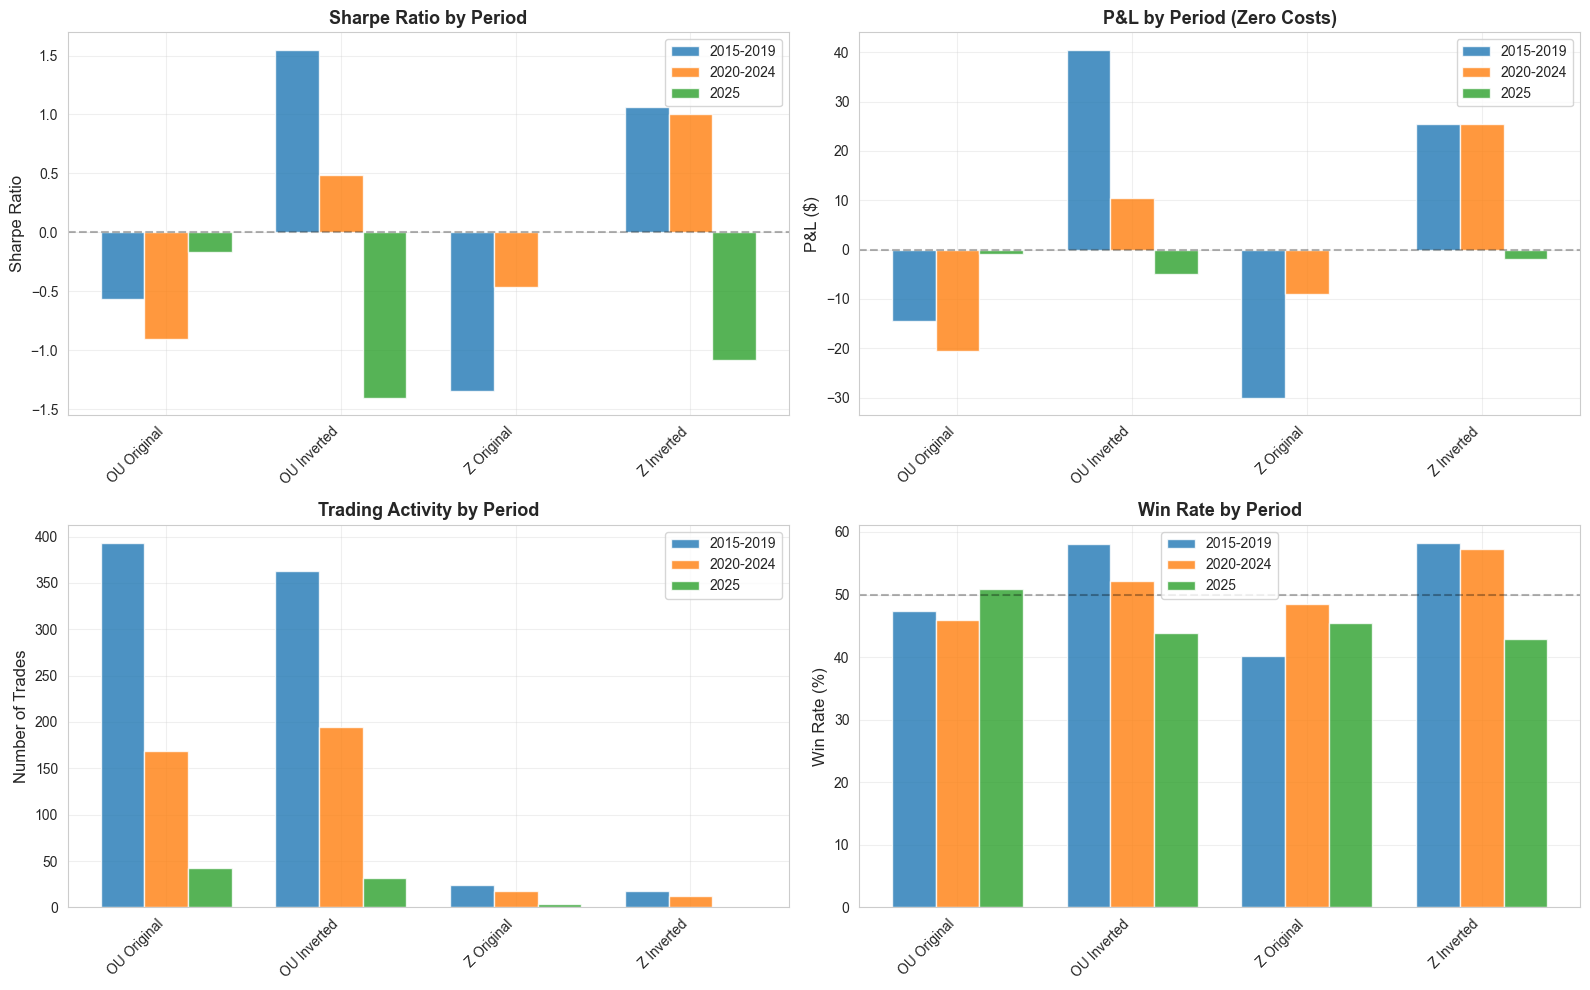


✓ Comparison charts saved


In [8]:
# Create bar chart comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

periods_list = ['2015-2019', '2020-2024', '2025']
strategies = ['OU Original', 'OU Inverted', 'Z Original', 'Z Inverted']
colors = ['steelblue', 'coral', 'lightblue', 'salmon']

# Sharpe Ratio
ax = axes[0, 0]
for period in periods_list:
    subset = comparison_df[comparison_df['period'] == period]
    x = np.arange(len(strategies))
    sharpes = [subset[subset['strategy'] == s]['sharpe'].values[0] for s in strategies]
    ax.bar(x + periods_list.index(period)*0.25, sharpes, width=0.25, 
           label=period, alpha=0.8)
ax.set_ylabel('Sharpe Ratio', fontsize=12)
ax.set_title('Sharpe Ratio by Period', fontsize=13, fontweight='bold')
ax.set_xticks(x + 0.25)
ax.set_xticklabels(strategies, rotation=45, ha='right')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax.legend()
ax.grid(True, alpha=0.3)

# P&L
ax = axes[0, 1]
for period in periods_list:
    subset = comparison_df[comparison_df['period'] == period]
    x = np.arange(len(strategies))
    pnls = [subset[subset['strategy'] == s]['pnl'].values[0] for s in strategies]
    ax.bar(x + periods_list.index(period)*0.25, pnls, width=0.25, 
           label=period, alpha=0.8)
ax.set_ylabel('P&L ($)', fontsize=12)
ax.set_title('P&L by Period (Zero Costs)', fontsize=13, fontweight='bold')
ax.set_xticks(x + 0.25)
ax.set_xticklabels(strategies, rotation=45, ha='right')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax.legend()
ax.grid(True, alpha=0.3)

# Trades
ax = axes[1, 0]
for period in periods_list:
    subset = comparison_df[comparison_df['period'] == period]
    x = np.arange(len(strategies))
    trades = [subset[subset['strategy'] == s]['trades'].values[0] for s in strategies]
    ax.bar(x + periods_list.index(period)*0.25, trades, width=0.25, 
           label=period, alpha=0.8)
ax.set_ylabel('Number of Trades', fontsize=12)
ax.set_title('Trading Activity by Period', fontsize=13, fontweight='bold')
ax.set_xticks(x + 0.25)
ax.set_xticklabels(strategies, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

# Win Rate
ax = axes[1, 1]
for period in periods_list:
    subset = comparison_df[comparison_df['period'] == period]
    x = np.arange(len(strategies))
    winrates = [subset[subset['strategy'] == s]['win_rate'].values[0] * 100 for s in strategies]
    ax.bar(x + periods_list.index(period)*0.25, winrates, width=0.25, 
           label=period, alpha=0.8)
ax.set_ylabel('Win Rate (%)', fontsize=12)
ax.set_title('Win Rate by Period', fontsize=13, fontweight='bold')
ax.set_xticks(x + 0.25)
ax.set_xticklabels(strategies, rotation=45, ha='right')
ax.axhline(y=50, color='black', linestyle='--', alpha=0.3)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/original_vs_inverted_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparison charts saved")

## 9. Summary

### What Changed

1. **Fixed Grid Search:**
   - Added validation to skip window sizes >= data length
   - Reduced parameter grid (removed 252, 504 day windows for validation)
   - No more "None of ['date'] are in the columns" errors

2. **Inverted Strategy:**
   - Original: Short spread when z > entry (bet on mean reversion)
   - Inverted: Long spread when z > entry (fade mean reversion / momentum)

3. **Cross-Period Testing:**
   - Tested both versions on 2015-2019, 2020-2024, 2025
   - All tests use ZERO transaction costs

### Key Questions to Answer

1. Does inverting the signals improve performance?
2. Is the P&L logic actually correct, or was it backwards?
3. Does either version generate meaningful alpha?

See comparison table and charts above for results.